In [2]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
import random
from math import pi, sqrt
import sys
import os.path
import matplotlib.pyplot as plt
import time

In [3]:
def renyi_calc(r,GA,epsilon=1e-9):
    """computes von Renyi entropy of 1d free fermions"""
    """GA: correlation matrix"""
   
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
#     return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r)

def EE_calc(GA,epsilon=1e-9):
    """computes von Neumann entanglement entropy of 1d free fermions"""
    """GA: correlation matrix"""
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
    return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))


def mut_inf_calc(Na,Nb,GA,epsilon=1e-9):
    """computes mutual information of 1d free fermions"""
    """GA: correlation matrix"""
    Nt=Na+Nb
    S12 = EE_calc(GA)
    S1 = EE_calc(GA[:Na,:Na])
    S2 = EE_calc(GA[Na:,Na:])
    return S1+S2-S12

def log_neg_calc(Na,Nb,Gm,epsilon=1e-9):
    """computes log negativity of 1d free fermions"""
    """Gm: covariance matrix of A and B"""
    """Na, Nb: number of complex fermions in A and B"""
    Nt=Na+Nb

    Gm_1= np.block([
        [-Gm[:2*Na,:2*Na], -1j*Gm[:2*Na,2*Na:]],
        [-1j*Gm[2*Na:,:2*Na], Gm[2*Na:,2*Na:]]
    ])
    Gm_2= np.block([
        [-Gm[:2*Na,:2*Na], 1j*Gm[:2*Na,2*Na:]],
        [1j*Gm[2*Na:,:2*Na], Gm[2*Na:,2*Na:]]
    ])
    Gx=np.eye(2*Nt)- np.dot(np.eye(2*Nt)+1j*Gm_2,np.dot(np.linalg.inv(np.eye(2*Nt)-np.dot(Gm_1,Gm_2)),np.eye(2*Nt)+1j*Gm_1))
    Gx=(Gx+np.transpose(Gx).conj())/2 # make sure it is hermitian

    chi0 =np.linalg.eigvalsh(Gx)
    i0=np.nonzero(np.abs(chi0-1)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1+1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(((1+nu+1j*0)/2)**0.5+((1-nu+1j*0)/2)**0.5))/2
    
    chi =np.linalg.eigvalsh(1j*Gm)
    sA=np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4    

    return np.real(eA+sA)


In [3]:
#### SSH chain sanity checks

N = 100
Lsub_list=np.arange(2,int(N/2)+1)
N_pt = int(N/2)
r=0.5

t=1.0
BC = -1
hop= np.diag(np.ones(N-1),1)
hop[N-1,0]= t*BC
H_t= -(hop+ np.matrix(hop).H)/2 
energies, evecs= np.linalg.eigh(H_t)
V1 =  evecs[:,:N_pt]
Gmat=np.dot(V1,np.matrix(V1).H)

Rr=np.zeros(len(Lsub_list)) # Renyi entropy
LN=np.zeros(len(Lsub_list)) # log neg

for i_L in range(len(Lsub_list)):
    Lsub=Lsub_list[i_L]
    inds_A= np.arange(0,Lsub_list[i_L])
    inds_AB= np.arange(0,int(2*Lsub_list[i_L]))

    Rr[i_L]=renyi_calc(r,Gmat[np.ix_(inds_A,inds_A)])
    Γ = np.kron(np.eye(2*Lsub)-2*Gmat[np.ix_(inds_AB,inds_AB)],[[0,1],[0,0]]) \
        -np.kron(np.eye(2*Lsub)-2*Gmat[np.ix_(inds_AB,inds_AB)],[[0,0],[1,0]])
    LN[i_L]=log_neg_calc(Lsub,Lsub,Γ)
#     LN[i_L]=log_neg_calc(Lsub,N-Lsub,Gmat)

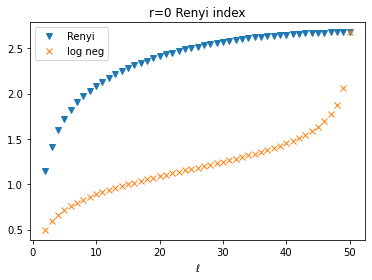

In [4]:
plt.figure()
#     plt.plot(Lsub_list,-Rr_ex,'o',label='(-1) Renyi Entropy')
plt.plot(Lsub_list,(Rr),'v',label='Renyi')
plt.plot(Lsub_list,(LN),'x',label='log neg')
plt.title('r=%d Renyi index' % (r))
plt.xlabel('$\ell$')
plt.legend()
plt.show()

In [11]:
### Kitaev chain Hamiltonian

def BdG_Hamiltonian(N,t,Δ,μ, Tm,BC):
    hopping = np.diag(np.ones(N-1),-1)
    hopping[0,N-1]=BC
    H = np.block([[-t*(hopping+hopping.T)-μ*np.eye(N), Δ*(hopping-hopping.T)],\
        [-Δ*(hopping-hopping.T),t*(hopping+hopping.T)+μ*np.eye(N)]])
    
    En, Vn = np.linalg.eigh(H/2)
    nF = np.diag(1/(1+np.exp(En/Tm)))
#     Uvec = np.matrix(Vn[:N,:N])
#     Vvec = np.matrix(Vn[N:,:N])
    Uvec = np.matrix(Vn[:N,:])
    Vvec = np.matrix(Vn[N:,:])
    Fmat = Uvec.dot(nF.dot(Vvec.H))
    Cmat = Vvec.dot(nF.dot(Vvec.H))
    Γ = 1j*np.kron(Fmat.H+Fmat+Cmat-Cmat.T,[[1,0],[0,0]])\
        -1j*np.kron(Fmat.H+Fmat-Cmat+Cmat.T,[[0,0],[0,1]])\
        +np.kron(np.eye(N)+Fmat.H-Fmat-Cmat-Cmat.T,[[0,1],[0,0]])\
        -np.kron(np.eye(N)+Fmat.H-Fmat-Cmat-Cmat.T,[[0,1],[0,0]]).T
    return Γ


# Adjacent intervals

In [23]:
δ = 0.
Tm = 5e-3
# from Haining's notes
t = -(1+δ)/2
Δ = t
μ = (1-δ)
Nc = 100
N = 2*Nc # number of majoranas
BC = -1

Gm = BdG_Hamiltonian(Nc,t,Δ,μ,Tm,BC)
Lsub_list=np.arange(2,int(N/3),2)
LN=np.zeros(len(Lsub_list)) # log neg

for i_L in range(len(Lsub_list)):
    Lsub=Lsub_list[i_L]
    inds_A= np.arange(0,Lsub_list[i_L])
    inds_AB= np.arange(0,int(2*Lsub_list[i_L]))

    LN[i_L]=log_neg_calc(int(Lsub/2),int(Lsub/2),Gm[np.ix_(inds_AB,inds_AB)])


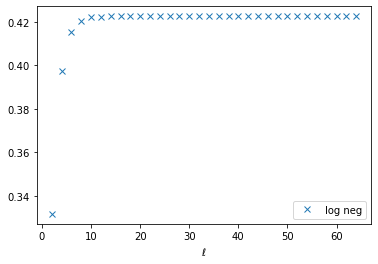

In [13]:
plt.figure()
plt.plot(Lsub_list,(LN)/np.log(2),'x',label='log neg')
plt.xlabel('$\ell$')
plt.legend()
plt.show()

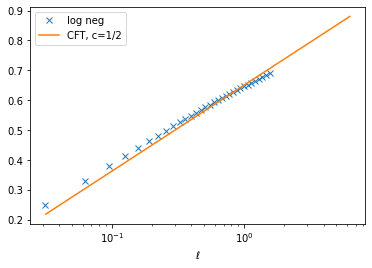

In [24]:
plt.figure()
# plt.plot(Lsub_list,(LN)/np.log(2),'x',label='log neg')
plt.plot(np.tan(pi*Lsub_list/N),(LN),'x',label='log neg')
xx = np.logspace(-1.5,0.8)
plt.plot(xx,np.log(xx)/8+0.65, label="CFT, c=1/2")
plt.xlabel('$\ell$')
plt.xscale("log")
plt.legend()
plt.show()

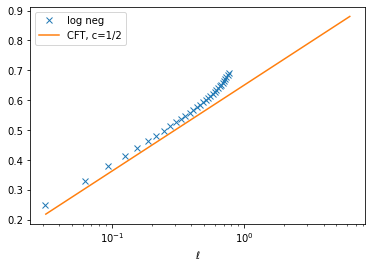

In [26]:
plt.figure()
# plt.plot(Lsub_list,(LN)/np.log(2),'x',label='log neg')
plt.plot(np.tanh(pi*Lsub_list*Tm),(LN),'x',label='log neg')
xx = np.logspace(-1.5,0.8)
plt.plot(xx,np.log(xx)/8+0.65, label="CFT, c=1/2")
plt.xlabel('$\ell$')
plt.xscale("log")
plt.legend()
plt.show()

# Bipartite negativity

In [49]:
δlist = np.linspace(-1,1,201)
Tm = 5e-3
Nc = 64
N = 2*Nc # number of majoranas
BC = -1

Lsub_list=np.array([8,16,32,64])
LN=np.zeros((len(δlist),len(Lsub_list))) # log neg

for i_d in range(len(δlist)):
    δ = δlist[i_d]
    t = -(1+δ)/2
    Δ = t
    μ = (1-δ)
    Gm = BdG_Hamiltonian(Nc,t,Δ,μ,Tm,BC)
    
    for i_L in range(len(Lsub_list)):
        Lsub=Lsub_list[i_L]
        inds_A= np.arange(0,Lsub)
#         inds_AB= np.arange(0,int(2*Lsub_list[i_L]))
        inds_AB= np.arange(0,N)

        LN[i_d,i_L]=log_neg_calc(int(Lsub/2),Nc-int(Lsub/2),Gm[np.ix_(inds_AB,inds_AB)])


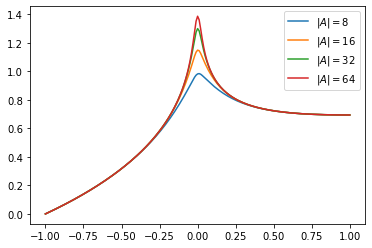

In [50]:
for i_L in range(len(Lsub_list)):
    plt.plot(δlist, LN[:,i_L],label=r"$ |A| = %d$" % (Lsub_list[i_L]))
plt.legend()
plt.show()